## Configuration and Data Setup

In [1]:
import os, urllib, shutil, tarfile, glob, warnings, json
import string, contractions, re, joblib
os.environ["USE_TF"] = "0"

from functools import partial
from dataclasses import dataclass, field
from typing import Callable
from time import time
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from torchmetrics import Accuracy

from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import WordLevel, WordPiece
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer
from transformers import AutoModel, DebertaV2Tokenizer, DataCollatorWithPadding

from src.trainer import trainer, evaluate
from src.nlu_eval import evaluate_samples, get_sample_reviews

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Torch Device: {device}")

Torch Device: cuda


In [2]:
# ---- Hyperparameter configuration ----

@dataclass
class HPARAMS:
    # common
    seed: int = 42
    url: str = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    scheduler_hparams: dict = field(default_factory=lambda: {
        "factor": 0.5,
        "patience": 2,
        "mode": "min"
    })
    
    # BiGRU hparams
    max_seq_len_gru: int = 256
    batch_size_gru: int = 128
    vocab_size: int = 10000
    glove_txt_path: str = ("/mnt/e/ML_Files/PreTrained_Models/GloVe_Embeddings/glove.2024.wikigiga"
                           ".200d/wiki_giga_2024_200_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt")
    
    model_hparams_gru: dict = field(default_factory=lambda: {
        "embedding_dim": 128,
        "hidden_size": 128,
        "dropout": 0.12,
        "num_gru_layers": 2,
        "use_dense": False,
        "dense_dropout_prob": 0.1
    })

    optimizer_hparams_gru: dict = field(default_factory=lambda: {
        "lr": 1e-3,
        "weight_decay": 5e-4
    })

    trainer_hparams_gru: dict = field(default_factory=lambda: {
        "n_epochs": 20,
        "use_early_stopping" : True,
        "early_stopping_patience" : 3,
        "scheduler_monitor" : "val_loss",
        "restore_best_model": True,
    })
    
    # Transformer hparams
    max_seq_len_transformer:int = 288
    #transformer_path: str = "/mnt/e/ML_Files/PreTrained_Models/HuggingFace/deberta-v3-base/"
    transformer_path: str = "/mnt/d/ML-Files/PreTrained-Models/HuggingFace/Transformer-Encoder/microsoft_deberta-v3-base/"
    batch_size_transformer: int = 32
    transformer_fc_dropout: float = 0.1
    
    optimizer_hparams_transformer: dict = field(default_factory=lambda: {
        "lr": 3e-5,
        "weight_decay": 5e-4
    })

    trainer_hparams_transformer: dict = field(default_factory=lambda: {
        "n_epochs": 5,
        "use_early_stopping" : True,
        "early_stopping_patience" : 2,
        "scheduler_monitor" : "val_loss",
        "restore_best_model": False,
    })
    
hp = HPARAMS()

In [3]:
# ---- Project Directory Setup ----

def project_dir_path(root_dir: str):
    """Create project directories (data, artifacts, model, tokenizer) and return their paths."""
    path_list = [os.path.join(root_dir, dir_) for dir_ in ["data", "artifacts", "model", "tokenizer"]]
    for p in path_list:
        os.makedirs(p, exist_ok=True)
    return path_list

ROOT_DIR = os.getcwd()
DATA_PATH, ARTIFACTS_PATH, MODEL_PATH, TOKENIZER_PATH = project_dir_path(ROOT_DIR)

In [4]:
# ---- IMDB Dataset Downloader ----

def sentinet_dataset_downloader(url, data_path):
    """Download and extract the IMDB dataset into data_path."""
    file_path = os.path.join(data_path, os.path.basename(url))
    if not os.path.exists(file_path):
        urllib.request.urlretrieve(url=url, filename=file_path)
        with tarfile.open(file_path, "r:gz") as tar:
            tar.extractall(path=data_path)
        # remove unnecessary unsupervised directory
        shutil.rmtree(os.path.join(data_path, "aclImdb/train/unsup"))
    return os.path.join(data_path, "aclImdb/train/"), os.path.join(data_path, "aclImdb/test/")

TRAIN_PATH, TEST_PATH = sentinet_dataset_downloader(hp.url, DATA_PATH)

In [5]:
# ---- Dataset Preparation Utilities ----

def read_text(path):
    """Read a text file and return its contents, or None on error."""
    try:
        with open(path, "r", encoding="utf-8") as f:
            return f.read()
    except Exception as e:
        warnings.warn(f"Error reading {os.path.basename(path)}: {e}")
        return None


def text_dataset_from_subdirs(root_path):
    """Load texts and labels from subdirectories under root_path."""
    subdirs = next(os.walk(root_path))[1]
    dataset = [
        (text, subdir)
        for subdir in subdirs
        for text in [read_text(p) for p in glob.glob(os.path.join(root_path, subdir, "*.txt"))]
        if text is not None
    ]
    print(f"Found {len(dataset)} text files across {len(subdirs)} classes")
    return dataset


def load_save_dataset(data_path, train_path=None, test_path=None):
    """Load IMDB dataset from disk or create CSVs if not present."""
    train_csv_path = os.path.join(data_path, "train.csv")
    test_csv_path = os.path.join(data_path, "test.csv")

    if not os.path.exists(train_csv_path):
        cols = ["text", "label"]
        mapper = {"pos": 1, "neg": 0}
        
        train = pd.DataFrame(text_dataset_from_subdirs(train_path), columns=cols)\
            .sample(frac=1.0, random_state=42)\
            .reset_index(drop=True)
        test = pd.DataFrame(text_dataset_from_subdirs(test_path), columns=cols)
        
        train["label"], test["label"] = train["label"].map(mapper), test["label"].map(mapper)
        train.to_csv(train_csv_path, index=False)
        test.to_csv(test_csv_path, index=False)

    return pd.read_csv(train_csv_path), pd.read_csv(test_csv_path)


In [6]:
# ---- Train/Validation/Test Split & Text Cleaning ----

train_full, test = load_save_dataset(DATA_PATH, TRAIN_PATH, TEST_PATH)
train, val = train_test_split(
    train_full,
    test_size=0.15,
    random_state=42,
    stratify=train_full.label,
    shuffle=True
)

# REMOVE BREAKLINE TAGS AND EXTRA WHITESPACES
tag_cleaner = re.compile('<.*?>') 

def quick_clean(text: str):
    """Remove HTML tags and extra whitespace from text."""
    assert isinstance(text, str), "inputs must be string object"
    text = re.sub(tag_cleaner, ' ', text)
    return " ".join(text.split())

train.text = train.text.map(quick_clean)
val.text = val.text.map(quick_clean)
test.text = test.text.map(quick_clean)

print(f"Train Shape: {train.shape} | Val Shape: {val.shape} | Test Shape: {test.shape}")

Train Shape: (21250, 2) | Val Shape: (3750, 2) | Test Shape: (25000, 2)


## Classic Models & TF-IDF Vectorization

In [9]:
# ---- Text Cleaning Utility ----

table = str.maketrans({ch: " " for ch in string.punctuation + string.digits})

def text_cleaning(text: str, fix_contractions: bool = True) -> str:
    """Lowercase, normalize contractions, strip tags/punctuation/digits, and clean whitespace."""
    assert isinstance(text, str), "text should be a string object"
    text = text.lower()
    if fix_contractions:
        text = contractions.fix(text)
    text = re.sub(r"<br\s*/?>", " ", text)
    text = text.translate(table)
    return " ".join(text.split())

In [7]:
# ---- TF-IDF Vectorization ----

keep = {
    "no", "not", "nor", "never", "none", "nothing", "nowhere", "hardly",
    "barely", "rarely", "seldom", "few", "little", "less", "more", "most",
    "very", "too", "enough"
}

# Custom stopwords list that preserves negations/intensifiers
sentiment_stopwords = list(ENGLISH_STOP_WORDS.difference(keep))

vectorizer = TfidfVectorizer(
    preprocessor=text_cleaning,
    stop_words=sentiment_stopwords,
    ngram_range=(1, 2),
    max_features=20000,
    dtype=np.float32
)

X_train = vectorizer.fit_transform(train.text)
X_val = vectorizer.transform(val.text)
y_train, y_val = train.label, val.label

In [8]:
# ---- Classic Model Selection ----

model_list = [
    LogisticRegression(n_jobs=-1, random_state=42),
    LinearSVC(random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42),
    AdaBoostClassifier(random_state=42),
    LGBMClassifier(n_jobs=-1, random_state=42, verbose=0),
    XGBClassifier(n_jobs=-1, random_state=42, verbose=0),
    MultinomialNB()
]

def model_selection(model_list, X_train, y_train, X_val, y_val):
    """Train/evaluate multiple models and return F1 scores with fit times."""
    results = []
    for model in tqdm(model_list, total=len(model_list)):
        start = time()
        model.fit(X_train, y_train)
        fit_time = time() - start
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        m_name = model.__class__.__name__
        results.append(
            (m_name, f1_score(y_train, train_preds), f1_score(y_val, val_preds), fit_time)
        )
    return (
        pd.DataFrame(results, columns=["Model", "Train_F1", "Validation_F1", "Fit_Time(s)"])
        .sort_values("Validation_F1", ascending=False)
        .round(3)
        .reset_index(drop=True)
    )

result = model_selection(model_list, X_train, y_train, X_val, y_val)
result.to_json(os.path.join(ARTIFACTS_PATH, "classic_model_selection_results.json"), index=False)

result

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:00<00:00,  8.67s/it]


,Model,Train_F1,Validation_F1,Fit_Time(s)
0,LogisticRegression,0.939,0.894,1.416
1,LinearSVC,0.993,0.890,0.404
2,MultinomialNB,0.906,0.872,0.009
3,LGBMClassifier,0.924,0.859,14.650
4,XGBClassifier,0.948,0.855,27.755
5,RandomForestClassifier,1.000,0.843,4.258
6,AdaBoostClassifier,0.763,0.751,11.543


In [18]:
# ---- Logistic Regression Hyperparameter Search & Pipeline ----

param_dist = {
    "penalty": ["l2", None],   
    "C": np.logspace(-4, 4, 20),                       
    "max_iter": [100, 200, 500, 1000],             
    "l1_ratio": np.linspace(0, 1, 5)               
}

random_search = RandomizedSearchCV(
    LogisticRegression(random_state=42),
    param_distributions=param_dist,
    n_jobs=-1, cv=4, refit=True,
    n_iter=200, scoring="f1", verbose=1
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print(f"Best RSCV Score: {random_search.best_score_:.3f}")

full_pipeline = Pipeline([
    ("vectorizer", vectorizer),
    ("predictor", best_model)
])
joblib.dump(full_pipeline, os.path.join(MODEL_PATH, "best_classic_model_pipeline.pkl"))

print(f"ValSet F1 Score: {f1_score(val.label, full_pipeline.predict(val.text)):.3f}")
print(f"TestSet F1 Score: {f1_score(test.label, full_pipeline.predict(test.text)):.3f}")

Fitting 4 folds for each of 200 candidates, totalling 800 fits
Best RSCV Score: 0.894
ValSet F1 Score: 0.897
TestSet F1 Score: 0.886


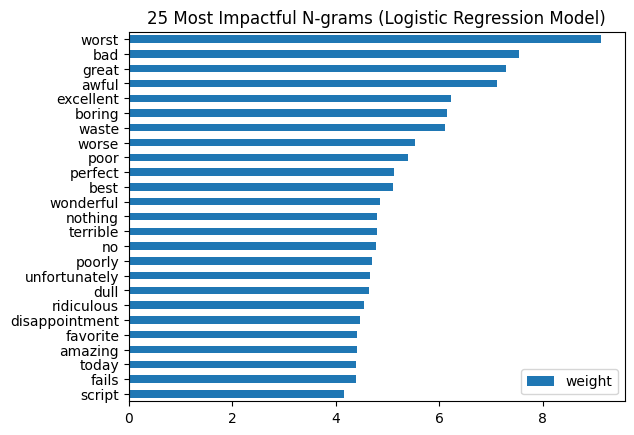

In [26]:
# ---- Top N-gram Feature Importance Visualization ----

ax = pd.DataFrame({
    "weight": np.abs(best_model.coef_[0])
}, index=vectorizer.get_feature_names_out())\
    .sort_values("weight", ascending=False)\
    .head(25).plot(kind="barh", title="25 Most Impactful N‑grams (Logistic Regression Model)")

ax.invert_yaxis()
ax.get_figure().savefig(
    os.path.join(ARTIFACTS_PATH, "top25_logreg_ngrams.jpg"),
    dpi=300,
    bbox_inches="tight"
)

In [17]:
# ---- Natural Language Understanding Evaluation ----

best_model = joblib.load(os.path.join(MODEL_PATH, "best_classic_model_pipeline.pkl"))
sample_reviews = [s["text"] for s in get_sample_reviews()]
postive_probs = best_model.predict_proba(sample_reviews)[:,1]
evaluate_samples(postive_probs)


Sample 1
Text       : The movie was short, simple, and absolutely wonderful.
Gold       : 1 (positive)
Difficulty : Simple positive — Straightforward positive sentiment, no ambiguity.
Predicted  : 1 (positive) with confidence 0.99

Sample 2
Text       : The first half was boring and predictable, but the ending completely blew me away.
Gold       : 1 (positive)
Difficulty : Shifting sentiment — Starts negative, ends positive — requires weighing overall tone.
Predicted  : 0 (negative) with confidence 0.89

Sample 3
Text       : Yeah, sure, this was the 'best' film ever... if you enjoy watching paint dry.
Gold       : 0 (negative)
Difficulty : Sarcasm — Positive words used sarcastically — model must detect irony.
Predicted  : 1 (positive) with confidence 0.72

Sample 4
Text       : The acting was decent, but the script was weak and the pacing dragged.
Gold       : 0 (negative)
Difficulty : Mixed but overall negative — Contains both positive and negative cues — requires nuance.
Predicted 

/home/hooman_wsl_aqr/miniconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['not'] not in stop_words.
  warnings.warn(


## BiDirectional GRU Network & WordPiece Tokenization

In [16]:
# ---- WordPiece Tokenizer Training ----

def word_piece_trainer(train_iterator, vocab_size, save_path):
    """Train a WordPiece tokenizer on the given iterator and save it to disk."""
    wp_tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
    wp_tokenizer.pre_tokenizer = Whitespace()
    wp_trainer = WordPieceTrainer(
        vocab_size=vocab_size,
        special_tokens=["[PAD]", "[UNK]"]
    )
    wp_tokenizer.train_from_iterator(train_iterator, wp_trainer)
    wp_tokenizer.save(os.path.join(save_path, "wordpiece_tokenizer.json"))
    print(f"trained tokenizer saved to: {save_path}")

word_piece_trainer(train.text.str.lower(), hp.vocab_size, TOKENIZER_PATH)




trained tokenizer saved to :/mnt/c/Users/ASUS/Documents/Machine-Learning/GitHUB/SentiNet/tokenizer


In [19]:
# ---- WordPiece Tokenizer Loading & Collate Function ----

wp_tokenizer = Tokenizer.from_file(os.path.join(TOKENIZER_PATH, "wordpiece_tokenizer.json"))
wp_tokenizer.enable_truncation(max_length=hp.max_seq_len_gru)
wp_tokenizer.enable_padding(pad_id=0, pad_token="[PAD]")

train_ds = list(zip(train.text.str.lower().to_list(), train.label.to_list()))
val_ds = list(zip(val.text.str.lower().to_list(), val.label.to_list()))

def collate_fn(batch, tokenizer):
    """Batch encode texts with WordPiece tokenizer and return tensors."""
    texts, labels = zip(*batch)
    encoded = tokenizer.encode_batch(texts)
    X = {
        "input_ids": torch.tensor([enc_sample.ids for enc_sample in encoded]),
        "attention_mask": torch.tensor([enc_sample.attention_mask for enc_sample in encoded])
    }
    return X, torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)

collate_fn_wp = partial(collate_fn, tokenizer=wp_tokenizer)

In [18]:
# ---- BiGRU Sentiment Classifier ----

class SentiNetBiGRU(nn.Module):
    """Bidirectional GRU model for sentiment classification with optional dense layer."""

    def __init__(self, vocab_size, use_pretrained_embedding=False,
                 embedding_layer=None, embedding_dim=128,
                 hidden_size=128, dropout=0.1,
                 num_gru_layers=2, use_dense=False,
                 dense_dropout_prob=0.1):
        
        super().__init__()
        self.hidden_size = hidden_size
        self.use_dense = use_dense
        self.num_gru_layers = num_gru_layers

        # Embedding layer (pretrained or trainable)
        if use_pretrained_embedding and (embedding_layer is not None):
            self.embedding = embedding_layer
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        emb_dim = self.embedding.embedding_dim   
        
        # Bidirectional GRU
        self.gru = nn.GRU(
            emb_dim, hidden_size,
            num_layers=num_gru_layers,
            dropout=(dropout if num_gru_layers > 1 else 0),
            batch_first=True,
            bidirectional=True
        )
        
        # Optional dense block
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 2 * hidden_size),
            nn.ReLU(),
            nn.Dropout(dense_dropout_prob)
        )
        self.output_layer = nn.Linear(2 * hidden_size, 1)

    def forward(self, inputs):
        """Forward pass: encode input_ids with GRU and return logits."""
        batch_size = inputs["input_ids"].size(0)
        
        embeddings = self.embedding(inputs["input_ids"])  # (N, L, E)
        lengths = inputs["attention_mask"].sum(axis=1)
        packed = pack_padded_sequence(
            embeddings, lengths=lengths.cpu(),
            batch_first=True, enforce_sorted=False
        )
        
        _, all_hidden = self.gru(packed)  # (D * num_layers, N, H)
        
        # Reshape to (D, num_layers, N, H)
        all_hidden = all_hidden.view(2, self.num_gru_layers, batch_size, self.hidden_size)
        
        # Take last layer hidden states (D, N, H)
        final_hidden = all_hidden[:, -1, :, :]
        final_hidden = final_hidden.permute(1, 0, 2).reshape(batch_size, -1)  # (N, 2*H)
        
        if self.use_dense:
            final_hidden = self.fc(final_hidden)
            
        return self.output_layer(final_hidden)  # (N, 1)

In [15]:
# ---- BiGRU Training Setup ----

torch.manual_seed(hp.seed)

train_loader = DataLoader(train_ds, batch_size=hp.batch_size_gru, 
                          collate_fn=collate_fn_wp, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=hp.batch_size_gru,
                        collate_fn=collate_fn_wp, shuffle=False, pin_memory=True)

model = SentiNetBiGRU(wp_tokenizer.get_vocab_size(), **hp.model_hparams_gru).to(device)

optimizer = torch.optim.Adam(model.parameters(), **hp.optimizer_hparams_gru)
loss_fn = nn.BCEWithLogitsLoss()
metric = Accuracy(task="binary").to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **hp.scheduler_hparams)

train_logs = trainer(model=model, optimizer=optimizer,
                     loss_fn=loss_fn, metric=metric,
                     device=device, train_loader=train_loader,
                     val_loader=val_loader, scheduler=scheduler,
                     **hp.trainer_hparams_gru
)

 Epoch 1/20, train_loss: 0.6750, train_metric : 0.5795, val_loss: 0.7223, val_metric: 0.5136, lr: 0.001, epoch_time: 18.47s
 Epoch 2/20, train_loss: 0.6776, train_metric : 0.5696, val_loss: 0.6803, val_metric: 0.5691, lr: 0.001, epoch_time: 18.07s
 Epoch 3/20, train_loss: 0.6525, train_metric : 0.6114, val_loss: 0.6275, val_metric: 0.6509, lr: 0.001, epoch_time: 18.93s
 Epoch 4/20, train_loss: 0.5811, train_metric : 0.7014, val_loss: 0.6031, val_metric: 0.6715, lr: 0.001, epoch_time: 17.84s
 Epoch 5/20, train_loss: 0.5211, train_metric : 0.7421, val_loss: 0.5163, val_metric: 0.7501, lr: 0.001, epoch_time: 18.75s
 Epoch 6/20, train_loss: 0.4369, train_metric : 0.7995, val_loss: 0.4483, val_metric: 0.7933, lr: 0.001, epoch_time: 18.87s
 Epoch 7/20, train_loss: 0.3793, train_metric : 0.8320, val_loss: 0.4396, val_metric: 0.7987, lr: 0.001, epoch_time: 18.05s
 Epoch 8/20, train_loss: 0.3483, train_metric : 0.8504, val_loss: 0.3822, val_metric: 0.8315, lr: 0.001, epoch_time: 18.98s
 Epoch 9

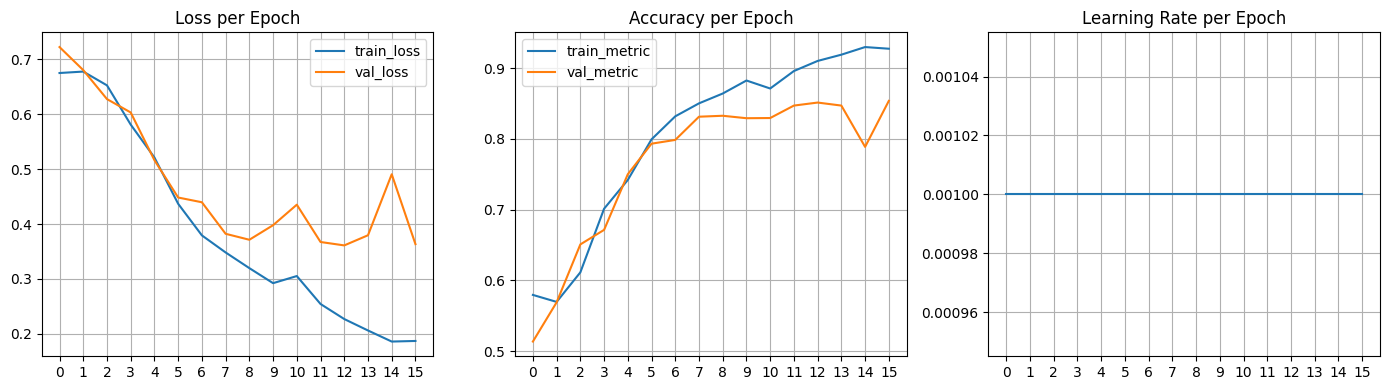

In [27]:
# ---- Training Curves Visualization ----

def learning_plots(train_logs, metric_name= None, lr = False):
    import pandas as pd
    import matplotlib.pyplot as plt
    results = pd.DataFrame(train_logs)
    n_epochs = len(results)
    fig, ax = plt.subplots(1,3 if lr else 2, figsize=(14,4))
    results[["train_loss", "val_loss"]].plot(ax=ax[0], title="Loss per Epoch", grid=True, xticks=range(n_epochs))
    results[["train_metric", "val_metric"]].plot(ax=ax[1],
            title=f"{metric_name if metric_name else 'Metric'} per Epoch" , grid=True, xticks=range(n_epochs))
    if lr:
        results["lr"].plot(title="Learning Rate per Epoch", grid=True, xticks=range(n_epochs))
    plt.tight_layout()
    return fig
    
fig = learning_plots(train_logs, metric_name="Accuracy", lr=True)
fig.savefig(os.path.join(ARTIFACTS_PATH, "BiGRU_WordPieceTokenizer_learning_plots.png"))

In [19]:
### SAVE TRAIN LOGS ###
with open(os.path.join(ARTIFACTS_PATH, "BiGRU_WordPieceTokenizer_train_logs.json"), "w") as f:
    json.dump(train_logs, f)

### SAVE MODEL PARAMETERS ###
torch.save(model.state_dict(), os.path.join(MODEL_PATH, "BiGRU_WordPieceTokenizer_params.pt"))

### EVALUATE MODEL ON TEST SUBSET ###
test_ds = list(zip(test.text.str.lower().to_list(), test.label.to_list()))
test_loader = DataLoader(
    test_ds,
    batch_size=hp.batch_size_gru,
    collate_fn=collate_fn_wp,
    shuffle=False,
    pin_memory=True
)

evaluate(model, metric, loss_fn, test_loader, device)

(0.36388808667507705, 0.8500000238418579)

In [51]:
# ---- Natural Language Understanding Evaluation ----

### LAOD BiGRU + WordPiece MODEL ###
gru_wordpiece_model = SentiNetBiGRU(wp_tokenizer.get_vocab_size(), **hp.model_hparams_gru).to(device)
gru_wordpiece_state_dict = torch.load(os.path.join(MODEL_PATH, "BiGRU_WordPieceTokenizer_params.pt"), map_location=device, weights_only=True)
gru_wordpiece_model.load_state_dict(gru_wordpiece_state_dict)

### INFERECNE ###
def inference_prep_fn(batch_texts):
    encoded = wp_tokenizer.encode_batch(batch_texts)
    return {
            "input_ids": torch.tensor([enc_sample.ids for enc_sample in encoded]),
            "attention_mask": torch.tensor([enc_sample.attention_mask for enc_sample in encoded])
        }

sample_reviews = [s["text"] for s in get_sample_reviews()]
sr_inputs = inference_prep_fn(sample_reviews)
with torch.no_grad():
    logits = gru_wordpiece_model(sr_inputs)
pos_probs = torch.sigmoid(logits)

evaluate_samples(pos_probs.numpy().flatten())


Sample 1
Text       : The movie was short, simple, and absolutely wonderful.
Gold       : 1 (positive)
Difficulty : Simple positive — Straightforward positive sentiment, no ambiguity.
Predicted  : 1 (positive) with confidence 0.97

Sample 2
Text       : The first half was boring and predictable, but the ending completely blew me away.
Gold       : 1 (positive)
Difficulty : Shifting sentiment — Starts negative, ends positive — requires weighing overall tone.
Predicted  : 0 (negative) with confidence 0.93

Sample 3
Text       : Yeah, sure, this was the 'best' film ever... if you enjoy watching paint dry.
Gold       : 0 (negative)
Difficulty : Sarcasm — Positive words used sarcastically — model must detect irony.
Predicted  : 1 (positive) with confidence 0.95

Sample 4
Text       : The acting was decent, but the script was weak and the pacing dragged.
Gold       : 0 (negative)
Difficulty : Mixed but overall negative — Contains both positive and negative cues — requires nuance.
Predicted 

## BiGRU & PreTrained GloVe Embeddings

In [7]:
# ---- WordLevel Tokenizer Training ----

def word_level_trainer(train_iterator, vocab_size, save_path):
    """Train a WordLevel tokenizer on the given iterator and save it to disk."""
    wl_tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
    wl_tokenizer.pre_tokenizer = Whitespace()
    wl_trainer = WordLevelTrainer(
        vocab_size=vocab_size,
        special_tokens=["[PAD]", "[UNK]"]
    )
    wl_tokenizer.train_from_iterator(train_iterator, wl_trainer)
    wl_tokenizer.save(os.path.join(save_path, "wordlevel_tokenizer.json"))
    print(f"trained tokenizer saved to: {save_path}")

word_level_trainer(train.text.str.lower(), hp.vocab_size, TOKENIZER_PATH)

trained tokenizer saved to :/mnt/c/Users/ASUS/Documents/Machine-Learning/GitHUB/SentiNet/tokenizer


In [55]:
# ---- Load GloVe Embeddings ----

def load_glove_embeddings(vocab: dict,
                          embedding_text_path: str,
                          emb_matrix_path: str,
                          emb_dim: int = 200,
                          seed: int = 42) -> np.ndarray:
    """Load vocab tokens' embeddings from GloVe into a numpy array."""
    vocab_size = len(vocab)
    if not os.path.exists(emb_matrix_path):
        embedding_matrix = np.zeros((vocab_size, emb_dim), dtype=np.float32)
        np.random.seed(seed)
        oov_vector = np.random.normal(scale=0.3, size=(emb_dim,))
        
        with open(embedding_text_path, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.rstrip().split(" ")
                word, vec = parts[0], np.asarray(parts[1:], dtype=np.float32)
                if word in vocab:
                    idx = vocab[word]
                    embedding_matrix[idx] = vec
        
        # Fill OOV tokens with random vector
        mask = np.all(embedding_matrix == 0, axis=1)
        embedding_matrix[mask] = oov_vector 
    
        # Handle special tokens
        pad_id = vocab.get("[PAD]")
        unk_id = vocab.get("[UNK]")
        
        if pad_id is not None:
            embedding_matrix[pad_id] = np.zeros((emb_dim,), dtype=np.float32)
        
        if unk_id is not None:
            embedding_matrix[unk_id] = oov_vector

        np.save(emb_matrix_path, embedding_matrix)
        print(f"Count of OOV Tokens: {mask.sum()}")
    else:
        embedding_matrix = np.load(emb_matrix_path)
    return embedding_matrix

In [57]:
# ---- Find Most Similar Words ----

def most_similar_words(word: str, vocab: dict, embedding_matrix: np.ndarray, k: int = 5):
    """Return the top-k most similar words to a given word using cosine similarity."""
    embedding_matrix = torch.from_numpy(embedding_matrix)
    word_id = vocab.get(word)
    if word_id is None:
        raise ValueError(f"Word '{word}' not in vocab")

    word_embedding = embedding_matrix[word_id]
    
    sims = F.cosine_similarity(word_embedding.unsqueeze(0), embedding_matrix, dim=1)
    
    topk_vals, topk_ids = sims.topk(k + 1)
    topk_ids, topk_vals = topk_ids[1:], topk_vals[1:]  # drop the query word itself
    
    inv_vocab = {idx: tok for tok, idx in vocab.items()}
    topk_tokens = [inv_vocab[idx.item()] for idx in topk_ids]
    
    return list(zip(topk_tokens, topk_vals.tolist()))

In [58]:
# ---- WordLevel Tokenizer + GloVe Embeddings + Similarity Check ----

wl_tokenizer = Tokenizer.from_file(os.path.join(TOKENIZER_PATH, "wordlevel_tokenizer.json"))
wl_tokenizer.enable_truncation(max_length=hp.max_seq_len_gru)
wl_tokenizer.enable_padding(pad_id=0, pad_token="[PAD]")

vocab = wl_tokenizer.get_vocab()
padding_id = wl_tokenizer.encode("[PAD]").ids[0]

glove_embedding_matrix = load_glove_embeddings(
    vocab,
    hp.glove_txt_path,
    os.path.join(ARTIFACTS_PATH, "glove_embeddings_matrix.npy")
)

glove_embedding_layer = nn.Embedding.from_pretrained(
    embeddings=torch.from_numpy(glove_embedding_matrix).float(),
    freeze=False,
    padding_idx=padding_id
)

most_similar_words("king", vocab, glove_embedding_matrix, k=8)

[('queen', 0.7260743975639343),
 ('prince', 0.7235743999481201),
 ('kingdom', 0.6820394396781921),
 ('throne', 0.6748451590538025),
 ('iii', 0.6674569249153137),
 ('ii', 0.6669546961784363),
 ('crown', 0.6513052582740784),
 ('reign', 0.6506226062774658)]

In [13]:
# ---- BiGRU + GloVe Training Setup ----

torch.manual_seed(hp.seed)

collate_fn_wl = partial(collate_fn, tokenizer=wl_tokenizer)

train_loader = DataLoader(train_ds, batch_size=hp.batch_size_gru,
                          collate_fn=collate_fn_wl,m shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=hp.batch_size_gru,
                        collate_fn=collate_fn_wl, shuffle=False, pin_memory=True)

model = SentiNetBiGRU( wl_tokenizer.get_vocab_size(), use_pretrained_embedding=True,
                       embedding_layer=glove_embedding_layer, **hp.model_hparams_gru).to(device)

optimizer = torch.optim.Adam(model.parameters(), **hp.optimizer_hparams_gru)
loss_fn = nn.BCEWithLogitsLoss()
metric = Accuracy(task="binary").to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **hp.scheduler_hparams)

train_logs = trainer(model=model, optimizer=optimizer,
    loss_fn=loss_fn, metric=metric,
    device=device, train_loader=train_loader,
    val_loader=val_loader, scheduler=scheduler,
    **hp.trainer_hparams
)

 Epoch 1/20, train_loss: 0.6198, train_metric : 0.6441, val_loss: 0.4389, val_metric: 0.8051, lr: 0.001, epoch_time: 18.67s
 Epoch 2/20, train_loss: 0.3966, train_metric : 0.8326, val_loss: 0.3717, val_metric: 0.8413, lr: 0.001, epoch_time: 16.67s
 Epoch 3/20, train_loss: 0.3161, train_metric : 0.8716, val_loss: 0.3163, val_metric: 0.8712, lr: 0.001, epoch_time: 18.56s
 Epoch 4/20, train_loss: 0.2631, train_metric : 0.8960, val_loss: 0.3597, val_metric: 0.8459, lr: 0.001, epoch_time: 16.65s
 Epoch 5/20, train_loss: 0.2405, train_metric : 0.9052, val_loss: 0.3186, val_metric: 0.8691, lr: 0.001, epoch_time: 17.35s
 Epoch 6/20, train_loss: 0.2100, train_metric : 0.9205, val_loss: 0.3085, val_metric: 0.8805, lr: 0.001, epoch_time: 17.83s
 Epoch 7/20, train_loss: 0.1846, train_metric : 0.9312, val_loss: 0.3763, val_metric: 0.8667, lr: 0.001, epoch_time: 18.41s
 Epoch 8/20, train_loss: 0.1715, train_metric : 0.9361, val_loss: 0.3402, val_metric: 0.8669, lr: 0.001, epoch_time: 16.74s
 Epoch 9

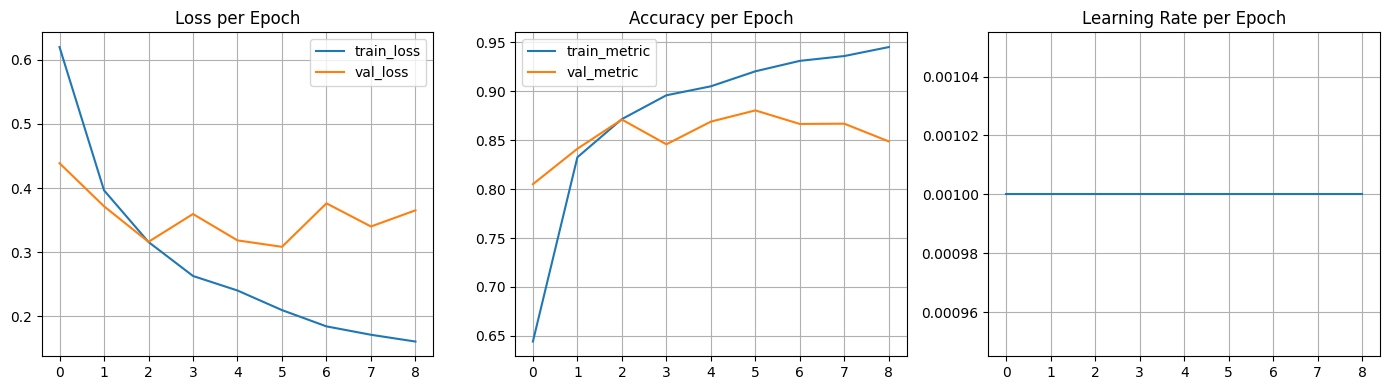

In [14]:
fig = learning_plots(train_logs, metric_name="Accuracy", lr=True)
fig.savefig(os.path.join(ARTIFACTS_PATH, "BiGRU_GloVe_learning_plots.png"))

In [15]:
### SAVE TRAIN LOGS ###
with open(os.path.join(ARTIFACTS_PATH, "BiGRU_GloVe_Embeddings_train_logs.json"), "w") as f:
    json.dump(train_logs, f)

### SAVE MODEL PARAMETERS ###
torch.save(model.state_dict(), os.path.join(MODEL_PATH, "BiGRU_GloVe_Embeddings_params.pt"))

### EVALUATE MODEL ON TEST SUBSET ###
test_ds = list(zip(test.text.str.lower().to_list() , test.label.to_list()))
test_loader = DataLoader(test_ds, batch_size = hp.batch_size_gru, collate_fn=collate_fn_wl, shuffle=False, pin_memory=True)

evaluate(model, metric, loss_fn, test_loader, device)

(0.31748838426203146, 0.8663600087165833)

In [59]:
# ---- Natural Language Understanding Evaluation ----

### LAOD BiGRU + GloVe MODEL ###
gru_glove_model = SentiNetBiGRU( wl_tokenizer.get_vocab_size(), use_pretrained_embedding=True,
                       embedding_layer=glove_embedding_layer, **hp.model_hparams_gru).to(device)

gru_glove_state_dict = torch.load(os.path.join(MODEL_PATH, "BiGRU_GloVe_Embeddings_params.pt"),
                                  map_location=device, weights_only=True)
gru_glove_model.load_state_dict(gru_glove_state_dict)

### INFERECNE ###
def inference_prep_fn(batch_texts):
    encoded = wl_tokenizer.encode_batch(batch_texts)
    return {
            "input_ids": torch.tensor([enc_sample.ids for enc_sample in encoded]),
            "attention_mask": torch.tensor([enc_sample.attention_mask for enc_sample in encoded])
        }

sample_reviews = [s["text"] for s in get_sample_reviews()]
sr_inputs = inference_prep_fn(sample_reviews)
with torch.no_grad():
    logits = gru_glove_model(sr_inputs)
pos_probs = torch.sigmoid(logits)

evaluate_samples(pos_probs.numpy().flatten())


Sample 1
Text       : The movie was short, simple, and absolutely wonderful.
Gold       : 1 (positive)
Difficulty : Simple positive — Straightforward positive sentiment, no ambiguity.
Predicted  : 1 (positive) with confidence 0.92

Sample 2
Text       : The first half was boring and predictable, but the ending completely blew me away.
Gold       : 1 (positive)
Difficulty : Shifting sentiment — Starts negative, ends positive — requires weighing overall tone.
Predicted  : 0 (negative) with confidence 0.88

Sample 3
Text       : Yeah, sure, this was the 'best' film ever... if you enjoy watching paint dry.
Gold       : 0 (negative)
Difficulty : Sarcasm — Positive words used sarcastically — model must detect irony.
Predicted  : 0 (negative) with confidence 0.59

Sample 4
Text       : The acting was decent, but the script was weak and the pacing dragged.
Gold       : 0 (negative)
Difficulty : Mixed but overall negative — Contains both positive and negative cues — requires nuance.
Predicted 

## Transformer-Based SentiNet

In [7]:
# ---- DeBERTa-v3 Tokenizer & Collate Function ----

### LOADING DEBERTAv3 TOKENIZER ###
deberta_tokenizer = DebertaV2Tokenizer.from_pretrained(hp.transformer_path)

text = "i Love DeeP Learningg!!!"
print(f"encoded text: {(enc := deberta_tokenizer.encode(text))}")
print(f"decoded ids: {deberta_tokenizer.decode(enc)}")
print(f"special tokens :{deberta_tokenizer.all_special_tokens}")

### PREPARE DATASET (NO LOWERCASING FOR DEBERTA) ###
train_ds = list(zip(train.text.to_list() , train.label.to_list()))
val_ds = list(zip(val.text.to_list() , val.label.to_list()))

### COLLATE FUNCTION WITH DYNAMIC PADDING ###
dynamic_padding_fn = DataCollatorWithPadding(deberta_tokenizer,
                                             padding=True,
                                             return_tensors="pt")

def collate_fn_pretrained(batch):
    texts, labels = zip(*batch)
    
    encoded = [
        deberta_tokenizer(
        t,
        add_special_tokens = True,
        max_length = hp.max_seq_len_transformer,
        truncation = True
    )
    for t in texts
    ]
    return dynamic_padding_fn(encoded), torch.tensor(labels, dtype=torch.float32).reshape(-1,1)

# ---- Notes on DataCollatorWithPadding ----
# - Expects already encoded samples (not raw text).
# - Apply truncation to max_len during encoding.
# - Do NOT batch encode; let DataCollatorWithPadding handle batching/padding.
# - Do NOT set max_len inside DataCollatorWithPadding, otherwise it forces fixed-length padding.

encoded text: [1, 584, 1961, 15267, 1230, 4735, 948, 300, 300, 300, 2]
decoded ids: [CLS] i Love DeeP Learningg!!![SEP]
special tokens :['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']


In [8]:
# ---- Transformer-based Sentiment Classifier ----

class SentiNetTransformer(nn.Module):
    """Sentiment classifier built on top of a pretrained Transformer backbone."""
    
    def __init__(self, model_path: str, fc_dropout: float = 0.1):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_path)
        hidden_dim = self.transformer.config.hidden_size

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(fc_dropout)
        )
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, encodings: dict):
        transformer_outputs = self.transformer(**encodings)  # last_hidden_state: (N, L, H)
        cls_embedding = transformer_outputs.last_hidden_state[:, 0, :]  # CLS token: (N, H)
        x = self.fc(cls_embedding)  # (N, H)
        return self.output(x)  # (N, 1)

In [10]:
# ---- Transformer SentiNet Training Setup ----
torch.manual_seed(hp.seed)

train_loader = DataLoader(train_ds, batch_size = hp.batch_size_transformer, num_workers=6,
                          collate_fn=collate_fn_pretrained, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size = hp.batch_size_transformer, num_workers=6,
                        collate_fn=collate_fn_pretrained, shuffle=False, pin_memory=True)

model = SentiNetTransformer(model_path=hp.transformer_path,
                            fc_dropout=hp.transformer_fc_dropout).to(device)
# MAGIC!

optimizer = torch.optim.Adam(model.parameters(), **hp.optimizer_hparams_transformer)
loss_fn = nn.BCEWithLogitsLoss()
metric = Accuracy(task="binary").to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

train_logs = trainer(model = model, optimizer = optimizer, loss_fn = loss_fn,
                         metric = metric, device = device, train_loader = train_loader,
                         val_loader = val_loader, scheduler=None, enable_mixed_precision=True,
                         **hp.trainer_hparams_transformer)

 Epoch 1/5, train_loss: 0.2229, val_loss: 0.1585, val_metric: 0.9432, lr: 3e-05, epoch_time: 355.52s
 Epoch 2/5, train_loss: 0.1469, val_loss: 0.1479, val_metric: 0.9469, lr: 3e-05, epoch_time: 354.08s
 Epoch 3/5, train_loss: 0.1350, val_loss: 0.1470, val_metric: 0.9483, lr: 3e-05, epoch_time: 355.27s
 Epoch 4/5, train_loss: 0.1259, val_loss: 0.1604, val_metric: 0.9501, lr: 3e-05, epoch_time: 353.72s
 Epoch 5/5, train_loss: 0.1192, val_loss: 0.1477, val_metric: 0.9480, lr: 3e-05, epoch_time: 355.00s
Early Stopping at Epoch: 5


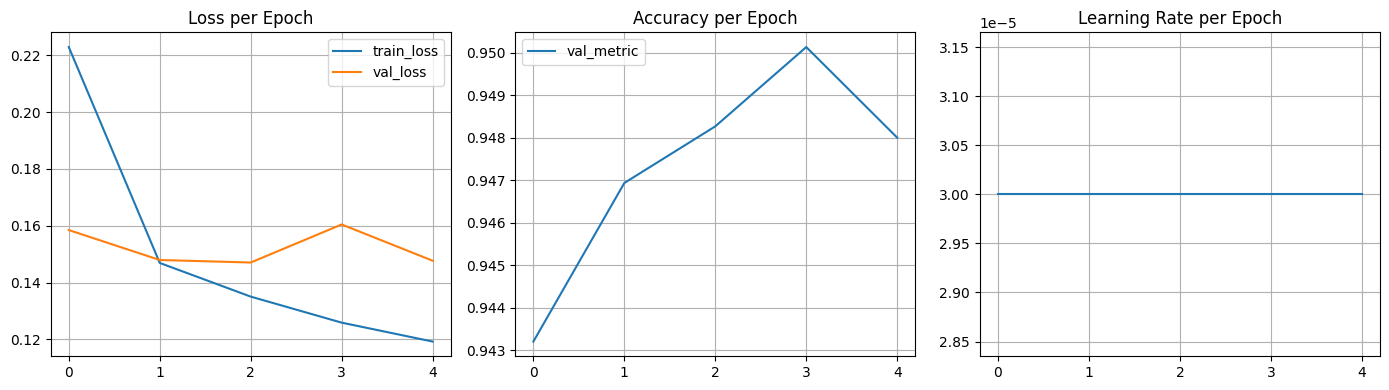

In [16]:
del train_logs["train_metric"]
fig = learning_plots(train_logs, metric_name="Accuracy", lr=True)
fig.savefig(os.path.join(ARTIFACTS_PATH, "SentiNet_Transformer_learning_plots.png"))

In [17]:
### SAVE TRAIN LOGS ###
with open(os.path.join(ARTIFACTS_PATH, "SentiNet_Transformer_train_logs.json"), "w") as f:
    json.dump(train_logs, f)

### SAVE MODEL PARAMETERS ###
torch.save(model.state_dict(), os.path.join(MODEL_PATH, "SentiNet_Transformer_params.pt"))

### EVALUATE MODEL ON TEST SUBSET ###
test_ds = list(zip(test.text.to_list(), test.label.to_list()))
test_loader = DataLoader(test_ds, batch_size = 64, collate_fn=collate_fn_pretrained, num_workers=6,
                         shuffle=False, pin_memory=True)

evaluate(model, metric, loss_fn, test_loader, device, enable_mixed_precision=True)

(0.12850436790491385, 0.9543600082397461)

In [26]:
# ---- Natural Language Understanding Evaluation ----

### LAOD SENTINET TRANSFORMER MODEL ###
sentinet_transformer = SentiNetTransformer(model_path=hp.transformer_path,
                    fc_dropout=hp.transformer_fc_dropout).to(device)

sentinet_transformer_state_dict = torch.load(os.path.join(MODEL_PATH, "SentiNet_Transformer_params.pt"),
                                              map_location=device, weights_only=True)
sentinet_transformer.load_state_dict(sentinet_transformer_state_dict)

### INFERECNE ###
sample_reviews = [s["text"] for s in get_sample_reviews()]
sr_inputs = deberta_tokenizer(sample_reviews, return_tensors="pt",
                              add_special_tokens=True, max_length = hp.max_seq_len_transformer,
                              truncation = True, padding=True)
sr_inputs = {k:v.to(device) for k,v in sr_inputs.items()}

with torch.no_grad():
    logits = sentinet_transformer(sr_inputs)
pos_probs = torch.sigmoid(logits)

evaluate_samples(pos_probs.cpu().numpy().flatten())


Sample 1
Text       : The movie was short, simple, and absolutely wonderful.
Gold       : 1 (positive)
Difficulty : Simple positive — Straightforward positive sentiment, no ambiguity.
Predicted  : 1 (positive) with confidence 1.00

Sample 2
Text       : The first half was boring and predictable, but the ending completely blew me away.
Gold       : 1 (positive)
Difficulty : Shifting sentiment — Starts negative, ends positive — requires weighing overall tone.
Predicted  : 1 (positive) with confidence 0.98

Sample 3
Text       : Yeah, sure, this was the 'best' film ever... if you enjoy watching paint dry.
Gold       : 0 (negative)
Difficulty : Sarcasm — Positive words used sarcastically — model must detect irony.
Predicted  : 0 (negative) with confidence 0.88

Sample 4
Text       : The acting was decent, but the script was weak and the pacing dragged.
Gold       : 0 (negative)
Difficulty : Mixed but overall negative — Contains both positive and negative cues — requires nuance.
Predicted 